# MNIST as a Matrix and Its SVD (Python Version)

This notebook illustrates the ideas from Section 1.2.2 using the MNIST dataset:

- We view a small batch of MNIST digits as a matrix.
- We compute its Singular Value Decomposition (SVD).
- We visualize:
  - the mean image,
  - a few leading singular directions (``eigendigits''),
  - reconstructions of a sample image with different ranks,
  - several views of the singular value spectrum.

The code is intentionally kept simple and laptop-friendly, and it saves figures
into the local `figs/` directory for inclusion in the notes.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

print("PyTorch version:", torch.__version__)

# Ensure figs/ directory exists for saving figures
os.makedirs("figs", exist_ok=True)

# -------------------------------------------------------------------
# 1. Load a small batch of MNIST digits
# -------------------------------------------------------------------
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

batch_size = 100  # small batch to keep SVD cheap
images = []
labels = []

for idx in range(batch_size):
    img, lab = mnist_train[idx]
    images.append(img.squeeze(0).numpy())  # img: 1x28x28 -> 28x28
    labels.append(lab)

images = np.stack(images, axis=0)  # shape: (batch_size, 28, 28)
labels = np.array(labels)

print("images.shape:", images.shape)


PyTorch version: 2.2.2
images.shape: (100, 28, 28)


In [2]:
# -------------------------------------------------------------------
# 2. Flatten, center, and compute SVD
# -------------------------------------------------------------------
batch_size, H, W = images.shape
D = H * W

# Flatten each image into a row vector
X = images.reshape(batch_size, D)  # shape: (batch_size, 784)

# Compute mean image and center
mean_image = X.mean(axis=0, keepdims=True)  # shape: (1, D)
X_centered = X - mean_image

# Compute SVD of the centered data matrix
# X_centered = U S V^T, with V^T containing principal directions in pixel space
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

print("X_centered.shape:", X_centered.shape)
print("U.shape:", U.shape)
print("S.shape:", S.shape)
print("Vt.shape:", Vt.shape)


X_centered.shape: (100, 784)
U.shape: (100, 100)
S.shape: (100,)
Vt.shape: (100, 784)


Saved figure to: figs/MNIST_SVD_panels.png


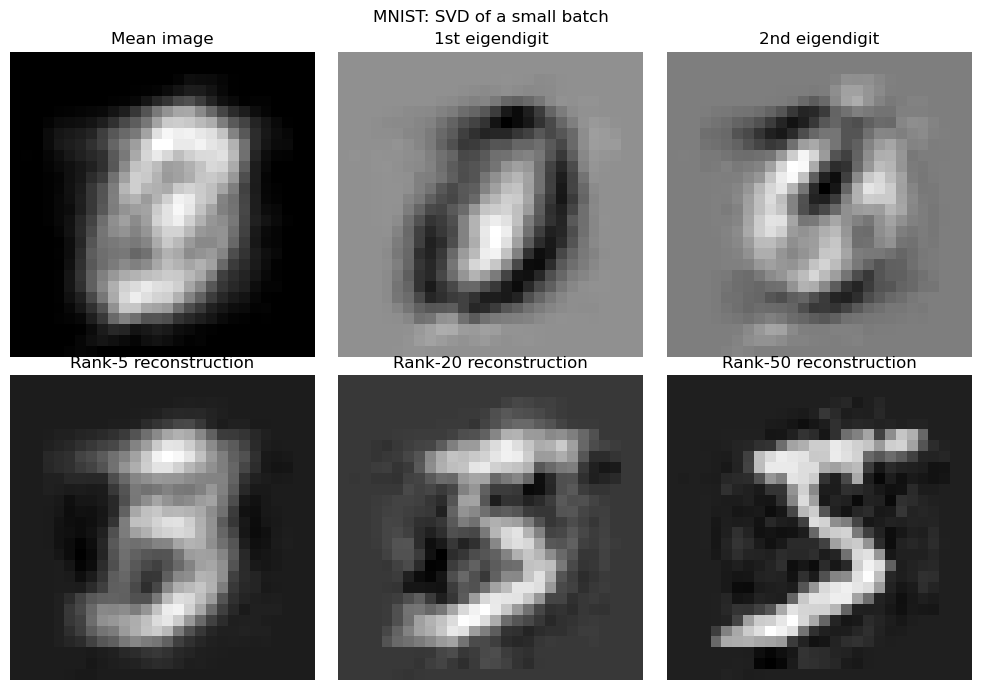

In [3]:
# -------------------------------------------------------------------
# 3. Summary figure:
#    - mean image
#    - first two principal directions (eigendigits)
#    - reconstructions of one sample image with different ranks
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

def show_image(ax, vec, title):
    img = vec.reshape(H, W)
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

# Panel (0,0): mean image
show_image(axes[0, 0], mean_image.ravel(), "Mean image")

# Panel (0,1) and (0,2): first two right-singular vectors (eigendigits)
show_image(axes[0, 1], Vt[0, :], "1st eigendigit")
show_image(axes[0, 2], Vt[1, :], "2nd eigendigit")

# Choose a sample index to reconstruct
sample_idx = 0
x_original = X[sample_idx : sample_idx + 1, :]       # shape: (1, D)
x_centered = x_original - mean_image

# Different ranks for reconstruction
ranks = [5, 20, 50]
for ax, r in zip(axes[1, :], ranks):
    Vr = Vt[:r, :]          # (r, D)
    coeffs = x_centered @ Vr.T
    x_rec = mean_image + coeffs @ Vr
    show_image(ax, x_rec.ravel(), f"Rank-{r} reconstruction")

fig.suptitle("MNIST: SVD of a small batch", y=0.98)
fig.tight_layout()

fig_path = os.path.join("figs", "MNIST_SVD_panels.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure to:", fig_path)

plt.show()


Saved spectral figure to: figs/MNIST_SVD_spectrum.png


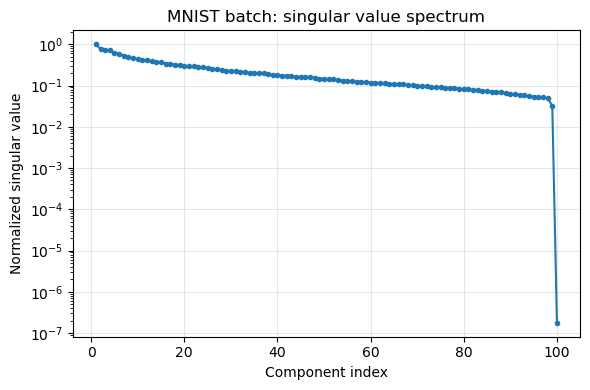

In [4]:
# -------------------------------------------------------------------
# 4. Spectral analysis: singular value spectrum (single batch)
# -------------------------------------------------------------------
sing_vals = S
sing_vals_norm = sing_vals / sing_vals[0]

fig, ax = plt.subplots(figsize=(6, 4))
ax.semilogy(np.arange(1, len(sing_vals_norm) + 1), sing_vals_norm, marker="o", markersize=3)
ax.set_xlabel("Component index")
ax.set_ylabel("Normalized singular value")
ax.set_title("MNIST batch: singular value spectrum")
ax.grid(alpha=0.3)

fig.tight_layout()
spec_path = os.path.join("figs", "MNIST_SVD_spectrum.png")
fig.savefig(spec_path, dpi=200, bbox_inches="tight")
print("Saved spectral figure to:", spec_path)

plt.show()


Saved composite spectral figure to: figs/MNIST_SVD_spectrum_composite.png


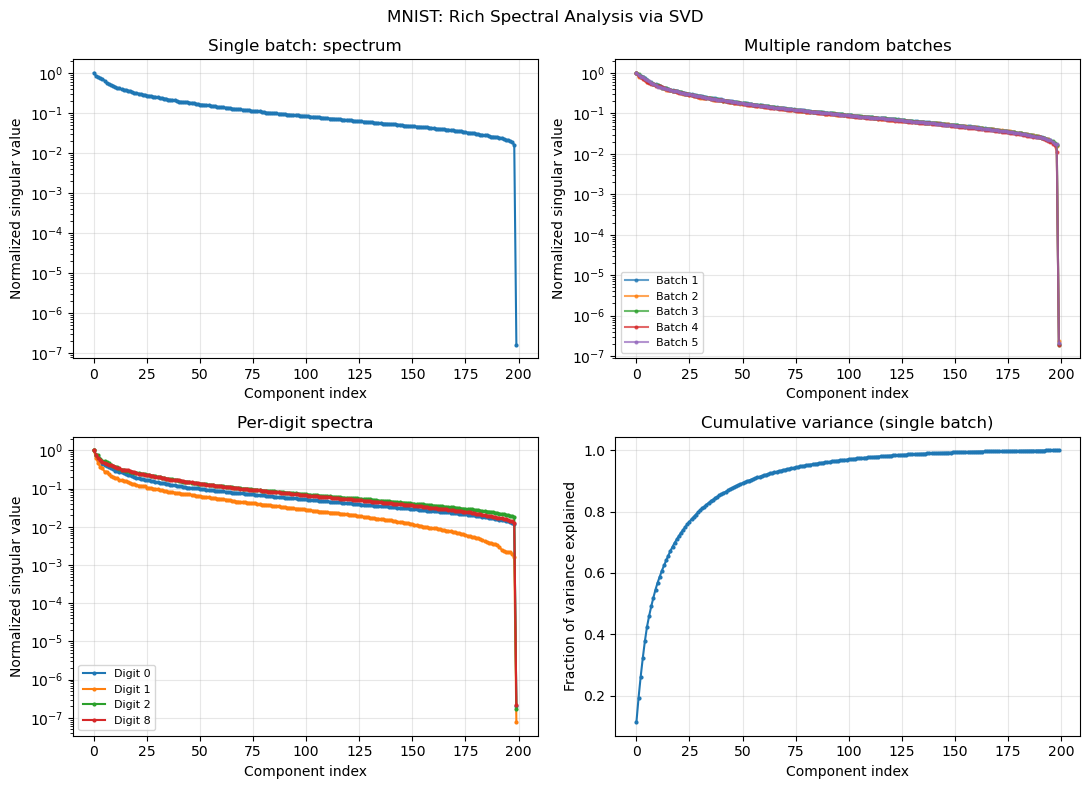

In [5]:
# -------------------------------------------------------------------
# 5. Rich spectral analysis: multiple batches, per-digit, and cumulative energy
# -------------------------------------------------------------------
def svd_spectrum_from_indices(indices):
    imgs = [mnist_train[i][0].numpy().squeeze() for i in indices]  # 28x28
    X_local = np.stack(imgs).reshape(len(indices), -1)
    X_c = X_local - X_local.mean(axis=0, keepdims=True)
    _, S_local, _ = np.linalg.svd(X_c, full_matrices=False)
    return S_local / S_local[0], S_local

# (A) Multiple random batches
num_batches = 5
batch_size_multi = 200
multi_specs = []

for _ in range(num_batches):
    idx = np.random.choice(len(mnist_train), batch_size_multi, replace=False)
    spec_norm, _ = svd_spectrum_from_indices(idx)
    multi_specs.append(spec_norm)

# (B) Per-digit spectra for a few classes
digits_to_use = [0, 1, 2, 8]
per_digit_specs = {}
n_per_class = 200

for d in digits_to_use:
    class_idx = [i for i, (_, lab) in enumerate(mnist_train) if lab == d][:n_per_class]
    spec_norm, _ = svd_spectrum_from_indices(class_idx)
    per_digit_specs[d] = spec_norm

# (C) Single canonical batch + cumulative energy
canon_batch_size = 200
canon_idx = np.arange(canon_batch_size)
canon_spec_norm, canon_S = svd_spectrum_from_indices(canon_idx)

energy = canon_S ** 2
cum_energy = np.cumsum(energy) / energy.sum()

# (D) Composite figure (2x2)
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# Top-left: single-batch spectrum (semilog)
ax = axes[0, 0]
ax.semilogy(canon_spec_norm, marker="o", markersize=2)
ax.set_title("Single batch: spectrum")
ax.set_xlabel("Component index")
ax.set_ylabel("Normalized singular value")
ax.grid(alpha=0.3)

# Top-right: multi-batch spectra
ax = axes[0, 1]
for i, spec in enumerate(multi_specs):
    ax.semilogy(spec, marker="o", markersize=2, alpha=0.7, label=f"Batch {i+1}")
ax.set_title("Multiple random batches")
ax.set_xlabel("Component index")
ax.set_ylabel("Normalized singular value")
ax.grid(alpha=0.3)
ax.legend(fontsize=8)

# Bottom-left: per-digit spectra
ax = axes[1, 0]
for d, spec in per_digit_specs.items():
    ax.semilogy(spec, marker="o", markersize=2, label=f"Digit {d}")
ax.set_title("Per-digit spectra")
ax.set_xlabel("Component index")
ax.set_ylabel("Normalized singular value")
ax.grid(alpha=0.3)
ax.legend(fontsize=8)

# Bottom-right: cumulative energy (single batch)
ax = axes[1, 1]
ax.plot(cum_energy, marker="o", markersize=2)
ax.set_title("Cumulative variance (single batch)")
ax.set_xlabel("Component index")
ax.set_ylabel("Fraction of variance explained")
ax.grid(alpha=0.3)

fig.suptitle("MNIST: Rich Spectral Analysis via SVD", y=0.98)
fig.tight_layout()

rich_path = os.path.join("figs", "MNIST_SVD_spectrum_composite.png")
fig.savefig(rich_path, dpi=200, bbox_inches="tight")
print("Saved composite spectral figure to:", rich_path)

plt.show()
